In [1]:
from Week1_Trapped_Ions.julia_run_random_circuit import run_random_circuit
from Week1_Trapped_Ions.utils import get_histogram_from_outcomes, draw_circles

/home/gwonhaklee/workspace/CohortProject_2021/venv/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


/home/gwonhaklee/workspace/CohortProject_2021/venv/lib/python3.8/site-packages/julia/core.py:687: FutureWarning: Accessing `Julia().<name>` to obtain Julia objects is deprecated.  Use `from julia import Main; Main.<name>` or `jl = Julia(); jl.eval('<name>')`.
  warnings.warn(


In [2]:
N = 3
D = 10
shots = 100
result = run_random_circuit(N, D, shots)

In [3]:
histogram_list = get_histogram_from_outcomes(result)

(<Figure size 1152x144 with 1 Axes>, <AxesSubplot:>)

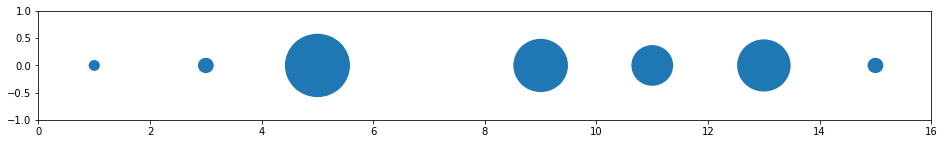

In [4]:
draw_circles(histogram_list)
